In [ ]:
## for google colab

# If encounter google drive issue, remount
# !rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install mne ipywidgets ipyevents nibabel trame trame-vtk trame-vuetify pyvista nilearn PyWavelets seaborn statsmodels mne_nirs snirf optuna sktime scikit-learn numpy pandas optuna

## 1. Load Library

In [ ]:
# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
)

# Import MNE processing
from mne.viz import plot_compare_evokeds


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np
import os
import mne
import snirf

from scipy import signal

INFO:pysnirf2:Library loaded by process 327


## 2. Define function

#### 2.0 Remove close channels

In [ ]:
def remove_close_channels(raw_intensity):
# Remove channels that are too close to each other (less than 1cm)
    picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True) # [0 ... 111]
    dists = mne.preprocessing.nirs.source_detector_distances(
        raw_intensity.info, picks=picks
    )
    raw_intensity.pick(picks[dists > 0.01]) # Number of channels with distance > 1 cm: 96

    return raw_intensity

#### 2.1 Annotation function

In [ ]:
def process_annotations(raw_intensity):

    # Define wanted stimuli
    wanted_stimulus = ["2", "3"]
    unwanted = np.nonzero(~np.isin(raw_intensity.annotations.description, wanted_stimulus))
    # The ~ operator is used to negate the result of np.isin
    raw_intensity.annotations.delete(unwanted)
    raw_intensity.annotations.rename(
        {"2": "Reappraise", "3": "view negative"}
    )

    return raw_intensity

# Usage:
# raw_intensity = process_annotations(raw_intensity)

#### 2.2 Wavelet motion Correction function

In [ ]:
import numpy as np
import pywt
import mne

def hmr_motion_correct_wavelet_standard(raw_od, iqr=1.5, turnon=1, wavename='db2'):
    if iqr < 0 or turnon == 0:
        return raw_od

    data = raw_od.get_data()
    dod_wavelet = np.zeros_like(data)
    signal_length = data.shape[1]
    n_levels = max(int(np.ceil(np.log2(signal_length))) - 4, 4) # decomposition level, L = 4 is the lowest wavelet scale used in the analysis

    # Identify bad channels
    bads = raw_od.info['bads']
    bad_indices = [raw_od.ch_names.index(bad) for bad in bads if bad in raw_od.ch_names]

    # Determine good channels
    all_indices = set(range(data.shape[0]))
    bad_indices_set = set(bad_indices)
    good_indices = sorted(all_indices - bad_indices_set)

    if not good_indices:
        print("All channels are marked as bad. No motion correction applied.")
        return raw_od.copy()


    for idx, channel_no in enumerate(good_indices):
        # Remove DC component
        dc_val = np.mean(data[channel_no, :])
        data_no_dc = data[channel_no, :] - dc_val

        # Normalize
        med_dev = np.median(np.abs(data_no_dc))
        if med_dev == 0:
            norm_coef = 1
            data_normalized = data_no_dc
        else:
            norm_coef = 1 / (1.4826 * med_dev)
            data_normalized = data_no_dc * norm_coef

        # Wavelet Transform
        coeffs = pywt.wavedec(data_normalized, wavename, mode='periodization', level=n_levels)

        # Thresholding (Artifact Removal)
        for i in range(1, len(coeffs)):
            c = coeffs[i]
            q1, q3 = np.percentile(c, [25, 75])
            iqr_val = q3 - q1
            threshold = iqr * iqr_val
            coeffs[i] = np.where((c > (q3 + threshold)) | (c < (q1 - threshold)), 0, c) # np.where(condition, value if true, value if false)

        # Inverse Wavelet Transform
        reconstructed = pywt.waverec(coeffs, wavename, mode='periodization')

        # Denormalize and add DC component
        reconstructed = reconstructed / norm_coef + dc_val

        # Truncate to original signal length
        dod_wavelet[channel_no, :] = reconstructed[:signal_length]

    # For bad channels, retain the original data
    if bad_indices:
        dod_wavelet[bad_indices, :] = data[bad_indices, :]
        print(f"Retained original data for {len(bad_indices)} bad channels.")

    raw_od_corrected = mne.io.RawArray(dod_wavelet, raw_od.info)
    return raw_od_corrected

#### 2.3 hmr_Bandpass_Filter function
(Auxiliary --> accelerometer/gyroscope data).
Both optical density and auxiliary data uses the same bandpass filter function

In [ ]:
def hmr_Bandpass_Filter(data, hpf=0.01, lpf=0.4):
    fs = data.info["sfreq"] # sampling frequency = 5.09 Hz
    if hpf > (fs/2) or lpf > (fs/2): # if bandpass filter > nyquist frequency
        print("Warning: Bandpass filter is larger than the Nyquist frequency")
        return data

    # Get the data array
    x = data.get_data()
    filtered_data = x.copy()

    # low-pass filter
    lpf_norm = lpf / (fs/2) #  The normalized lpf_norm = 0.157 indicates that the low-pass cutoff is at 15.7% of the Nyquist frequency.
    if lpf_norm > 0:
        # Create filter
        filter_order = 3
        # Design an 3rd-order digital Butterworth filter and return the filter coefficients.
        b, a = signal.butter(filter_order, lpf_norm, 'low')  # butter(N, Wn, btype='low')
            # N: The order of the filter
            # For digital filters, if fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
            # btype {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, optional, The type of filter. Default is ‘lowpass’.

        for ch in range(x.shape[0]):
            filtered_data[ch, :] = signal.filtfilt(b, a, filtered_data[ch, :]) # b : The numerator coefficient vector; a : The denominator coefficient vector

    # High-pass filter
    hpf_norm = hpf / (fs/2)
    if hpf_norm > 0:
        filter_order_h = 5
        b_h, a_h = signal.butter(filter_order_h,hpf_norm, 'high')
        for ch in range(x.shape[0]):
            filtered_data[ch, :] = signal.filtfilt(b_h, a_h, filtered_data[ch, :])

    data_filtered = data.copy()
    data_filtered._data = filtered_data

    return data_filtered




#### 2.4 Define MotionCorrectCbsi function

This function assumes that the true psychological signals of HbO and HbR are negatively correlated

Page 5 of https://doi.org/10.3390/s23083979

In [ ]:
def hmrR_MotionCorrectCbsi(raw_haemo):

    hbo_channels = [ch for ch in raw_haemo.ch_names if 'hbo' in ch.lower()]
    hbr_channels = [ch for ch in raw_haemo.ch_names if 'hbr' in ch.lower()]

    hbo_indices = [idx for idx, ch in enumerate(raw_haemo.ch_names) if 'hbo' in ch.lower()] # [0-47]
    hbr_indices = [idx for idx, ch in enumerate(raw_haemo.ch_names) if 'hbr' in ch.lower()] #[48-95]

    haemo_data = raw_haemo.get_data() # (96, 2396)
    n_timepoints = haemo_data.shape[1] # 2396
    n_channels = len(hbo_channels) # 48

    data_dc = np.zeros((n_timepoints, 3 ,n_channels)) # (2396, 3, 48)
    data_dc[:,0,:] = haemo_data[hbo_indices,:].T
    data_dc[:,1,:] = haemo_data[hbr_indices,:].T

    # avoid changing original data
    dc = data_dc.copy()

    # Copy data for correction
    dcCbsi = dc.copy()

    for idx_ch in range(n_channels):

        # Mean-center the HbO and HbR signals
        dc_oxy = dc[:, 0, idx_ch] - np.mean(dc[:, 0, idx_ch])
        dc_deoxy = dc[:, 1, idx_ch] - np.mean(dc[:, 1, idx_ch])

        # Calculate standard deviations
        sd_oxy = np.std(dc_oxy, ddof=0) #Delta Degrees of Freedom = 0: divides by n
        sd_deoxy = np.std(dc_deoxy, ddof=0)

        # Compute alpha, avoiding division by zero
        if sd_deoxy != 0:
            alfa = sd_oxy / sd_deoxy
        else:
            alfa = 0

        # Apply CBSI correction
        dcCbsi[:, 0, idx_ch] = 0.5 * (dc_oxy - alfa * dc_deoxy)
        if alfa != 0:
            dcCbsi[:, 1, idx_ch] = - (1 / alfa) * dcCbsi[:, 0, idx_ch]
        else:
            dcCbsi[:, 1, idx_ch] = 0  # Handle division by zero

        dcCbsi[:, 2, idx_ch] = dcCbsi[:, 0, idx_ch] + dcCbsi[:, 1, idx_ch]

    raw_copy = raw_haemo.copy()

    # Step 4: Extract and replace HbO and HbR data
    corrected_hbo = dcCbsi[:, 0, :].T  # Shape: (n_channels, n_timepoints)
    corrected_hbr = dcCbsi[:, 1, :].T  # Shape: (n_channels, n_timepoints)

    # Replace data in-place
    raw_copy._data[hbo_indices, :] = corrected_hbo
    raw_copy._data[hbr_indices, :] = corrected_hbr

    # Step 5: Add HbT channels
    corrected_hbt = dcCbsi[:, 2, :].T  # Shape: (n_channels, n_timepoints)

    # Define HbT channel names
    hbt_channels = [ch.replace('hbo', 'hbt') for ch in hbo_channels]

    # Define channel types for HbT
    hbt_channel_types = ['misc'] * n_channels  # 'misc' since 'hbt' is not standard in MNE

    # Create Info object for HbT channels
    hbt_info = mne.create_info(ch_names=hbt_channels, sfreq=raw_copy.info['sfreq'], ch_types=hbt_channel_types)

    # Create RawArray for HbT channels
    raw_hbt = mne.io.RawArray(corrected_hbt, hbt_info)

    # Add HbT channels to the Raw copy
    raw_copy.add_channels([raw_hbt], force_update_info=True)

    return raw_copy

#### 2.5 Define get ROI channel function

take away 'hbr' data to reduce redundancy

In [ ]:
def get_ROI_channels(raw_copy):
    # Get channel names from your fNIRS dataset
    channel_names = raw_copy.ch_names

    # Define the selection criteria
    selection_criteria = ['S2', 'S4', 'S5', 'S6']

    # Create a list to store selected channel names
    selected_channels = []

    for channel in channel_names:
        if any(criterion in channel for criterion in selection_criteria) and ('hbo' in channel or 'hbr' in channel or 'hbt' in channel): #HbO channels: 760nm HbR channels: 850nm
            selected_channels.append(channel)

    # Now, get the indices of these selected channels
    picks = [channel_names.index(name) for name in selected_channels]

    return picks

#### 2.6 Define get evoked metadata for Reappraise / view negative

In [ ]:
def get_evoked_metadata(raw_copy, events, event_dict, picks):
    # Rejection criteria for bad epochs
    reject_criteria = dict(hbo=70e-6)

    epochs = mne.Epochs(raw_copy,
                       events,
                       event_id=event_dict,
                       tmin=-2,
                       tmax=20,
                       picks=picks,
                       baseline=(-2, 0),
                       reject=reject_criteria,
                       preload=True,
                       verbose=False)

    # Get rejected epochs information
    drop_log = epochs.drop_log
    dropped_indices = [i for i, drops in enumerate(drop_log) if drops]

    print(f"\nNumber of rejected epochs: {len(dropped_indices)}")
    print("\n")
    print("\nRejected epochs event types:")
    for i in dropped_indices:
        event_type = events[i][2]
        print(f"Epoch {i}: Event type {event_type}")


    # Separate epochs by condition and channel type
    epochs_dict = {
        "Reappraise": {
            "HbO": np.mean(epochs["Reappraise"].average(picks="hbo").data, axis = 1),  # average over time
        },
        "view_negative": {
            "HbO": np.mean(epochs["view negative"].average(picks="hbo").data, axis=1),  # average over time
        }
    }

    # Get channel names for each type
    hbo_ch_names = [ch for ch in epochs.ch_names if 'hbo' in ch.lower()]


    # Remove frequency encoding from channel names
    hbo_ch_names = [ch[:-4] for ch in hbo_ch_names]


    # Create metadata DataFrames
    metadata_df_reappraise = pd.DataFrame({
        'epoch': range(len(epochs["Reappraise"])),
        'condition': 'Reappraise',
        'times': [epochs.times] * len(epochs["Reappraise"]),
        'hbo_ch_names': [hbo_ch_names] * len(epochs["Reappraise"]),
    })

    metadata_df_view_negative = pd.DataFrame({
        'epoch': range(len(epochs["view negative"])),
        'condition': 'view_negative',
        'times': [epochs.times] * len(epochs["view negative"]),
        'hbo_ch_names': [hbo_ch_names] * len(epochs["view negative"]),
    })

    return epochs_dict, metadata_df_reappraise, metadata_df_view_negative, epochs.times

#### 2.7 Define interpolation function

In [ ]:
# identifies bad fNIRS channels via scalp coupling index, interpolates them
def interpolate_bad_channels(raw_od, sci_value):
    # Make a copy for preprocessing
    raw_od_copy = raw_od.copy()

    # Set montage
    montage = raw_od_copy.get_montage()
    raw_od_copy.set_montage(montage)

    # Calculate scalp coupling index
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od_copy)

    # Mark bad channels based on SCI
    raw_od_copy.info["bads"] = list(compress(raw_od_copy.ch_names, sci < sci_value))
    # print(f"Bad channels before interpolation: {raw_od_copy.info['bads']}") #####################################################
    # Interpolate bad channels
    raw_od_copy.interpolate_bads(
        reset_bads=False,      # Keep bad channels in the bads list after interpolation
        mode='accurate',       # Use high-quality interpolation
        method="nearest"       # Specify interpolation method for fNIRS channels
    )
    # print(f"Bad channels after interpolation: {raw_od.info['bads']}") #########################################################
    # Create a RawArray with processed data and original info
    processed_data = raw_od_copy.get_data()
    original_info = raw_od.info.copy()

    # Create new Raw object
    raw_od = mne.io.RawArray(processed_data, original_info)

    return raw_od

## 3. Subject Level Analysis

Each person has 12 metadata, every metadata is a 2D matrix of shape {39 channels [HbO, HbR, HbT], 113 timepoints [-2 to 20s]}

In [ ]:
import os
import mne
import numpy as np
from glob import glob
import mne_nirs
import logging

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Fiducial point nasion not found, assuming identity unknown to head transformation", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="No bad channels to interpolate. Doing nothing...", category=RuntimeWarning)

base_dir = r"/content/drive/MyDrive/fNIRS data/neurofeedback"
participant_id = 1

def subject_wise_analysis_1_to_6(base_dir, participant_id, ROI=True):
    participant_dir = os.path.join(base_dir, f"p{participant_id:02d}")

    # Find all directories that have at least one underscore in their name
    date_dirs = glob(os.path.join(participant_dir, "????-??-??_???"))

    if not date_dirs:
        print(f"No data directories found for participant {participant_id}")
        return None, None, None

    # Initialize dictionary to store epochs
    all_epochs_dict = {

            "Reappraise": {
                "HbO": []
            },
            "view_negative": {
                "HbO": []
            }

    }

    run_numbers = [run[-3:] for run in date_dirs]
    # print("All run numbers:", run_numbers)

    # Get only run 001
    sorted_runs = sorted(run_numbers)
    first_run = [sorted_runs[0]]  # Get only first run (001)

    selected_runs = [run for run in date_dirs if run[-3:] in first_run]

    for run in selected_runs:
        run_num = run[-3:]
        print("\nRun", run_num)
        snirf_files = glob(os.path.join(run, "*.snirf"))

        if not snirf_files:
            print(f"No SNIRF file found in {run}")
            continue

        fnirs_snirf = snirf_files[0]

        # Load raw intensity info
        raw_intensity = mne.io.read_raw_snirf(fnirs_snirf, preload=True)
        raw_intensity.load_data()

        # Process the data
        raw_intensity = process_annotations(raw_intensity)
        raw_intensity = remove_close_channels(raw_intensity)
        raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
        raw_od = interpolate_bad_channels(raw_od, sci_value=0.9)
        raw_od_wavelet = hmr_motion_correct_wavelet_standard(raw_od, iqr=1.5, turnon=1, wavename='db2')
        raw_od_wavelet_filtered = hmr_Bandpass_Filter(raw_od_wavelet, hpf=0.01, lpf=0.4)
        raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_wavelet_filtered, ppf=6.0)
        raw_copy = hmrR_MotionCorrectCbsi(raw_haemo)

        # Get channels
        if ROI:
            picks = get_ROI_channels(raw_copy)
            hbo_ch_names = [ch for ch in np.array(raw_copy.ch_names)[picks] if 'hbo' in ch.lower()]
        else:
            picks = list(range(len(raw_copy.ch_names)))
            hbo_ch_names = [ch for ch in raw_copy.ch_names if 'hbo' in ch.lower()]

        # Get epochs
        events, event_dict = mne.events_from_annotations(raw_intensity)
        epochs_dict, metadata_df_reappraise, metadata_df_view_negative, epochs_times = get_evoked_metadata(
            raw_copy, events, event_dict, picks)

        # Store epochs in the dictionary
        all_epochs_dict["Reappraise"]["HbO"] = epochs_dict["Reappraise"]["HbO"]
        all_epochs_dict["view_negative"]["HbO"] = epochs_dict["view_negative"]["HbO"]

    # Convert lists to numpy arrays and print shapes
    for condition in all_epochs_dict:
          all_epochs_dict[condition]["HbO"] = np.array(all_epochs_dict[condition]["HbO"])
          array_shape = all_epochs_dict[condition]["HbO"].shape
          print(f"Participant {participant_id} - {condition}: {array_shape}")

    return all_epochs_dict, epochs_times, hbo_ch_names

In [ ]:
all_epochs_dict, epochs_time, hbo_ch_names =subject_wise_analysis_1_to_6(base_dir, participant_id, ROI=True)
print(all_epochs_dict)



Run 001

Number of rejected epochs: 0



Rejected epochs event types:
Participant 1 - Reappraise: (13,)
Participant 1 - view_negative: (13,)
{'Reappraise': {'HbO': array([ 6.42470800e-08,  7.40716326e-08,  1.48861541e-08,  3.96452970e-08,
       -2.53012675e-09,  3.93469066e-08,  2.12135430e-08,  4.93735923e-08,
        3.75904438e-08,  1.22373408e-08,  4.97176675e-08,  4.24024541e-08,
        1.52321513e-08])}, 'view_negative': {'HbO': array([-8.11709026e-08, -9.95629926e-08, -6.05969031e-08,  1.15628102e-08,
        2.29510115e-08,  3.35584298e-08,  6.56851344e-09, -1.47226080e-08,
       -1.04553863e-08, -2.29109197e-08,  2.75062621e-08, -7.46029532e-09,
       -1.69376182e-08])}}


## 4. get all participants' data

1. If a channel is bad in any run, it might be unreliable in other runs too
2. For group analysis, we need consistent channel layouts across all runs
3. So, we remove channels marked as bad in any run from all runs

In [ ]:
import numpy as np
from scipy import stats

def process_fnirs_data():

    # We reject participant's data if the negativity reaponse pattern happens to be "invariant responding", which is a clear indicator of low-quality data

    base_dir = r"/content/drive/MyDrive/fNIRS data/neurofeedback" # google colab: r"/content/drive/MyDrive/fNIRS data/neurofeedback"
    participant_ids= [1,3,6,7,10,11,13,15,16,17,20,21,24,28,30,31,33,37,38,40,41,43,45,46,48,50,55,56] # google colab: [1,3,6,7,8,10,11,13,15,16,17,20,21,24,28,30,31,33,37,38,40,41,43,45]
      # reject p8 as 51/63 responses are 1s (79.7%), 13/64 responses are 2s
    base_dir_sham = r"/content/drive/MyDrive/fNIRS data/sham"
    participants_id_sham = [2,5,9,12,14,18,19,22,23,25,26,27,29,34,35,36,39,42,44,47,49,51,52,53,54]
      # reject p4 as 56/63 responses are 1s (88.9%), 7/64 responses are 2s
      # reject p32 as 60/64 responses are 1s (93.75%), 4/64 responses are 2s

    # Initialize empty lists for features (X) and labels (y)
    X = []  # Will store all HbO data
    y = []  # Will store corresponding labels (0 for view_negative, 1 for Reappraise)

    # Process neurofeedback group
    for participant_id in participant_ids:
        participant_epochs,_,_ = subject_wise_analysis_1_to_6(base_dir, participant_id, ROI=True)

        # Add Reappraise data
        if participant_epochs['Reappraise']['HbO'].size > 0:
            X.append(participant_epochs['Reappraise']['HbO'])
            y.append(1)  # Label 1 for Reappraise

        # Add view_negative data
        if participant_epochs['view_negative']['HbO'].size > 0:
            X.append(participant_epochs['view_negative']['HbO'])
            y.append(0)  # Label 0 for view_negative

    # Process sham group
    for participant_id in participants_id_sham:
        participant_epochs,_,_ = subject_wise_analysis_1_to_6(base_dir_sham, participant_id, ROI=True)

        # Add Reappraise data
        if participant_epochs['Reappraise']['HbO'].size > 0:
            X.append(participant_epochs['Reappraise']['HbO'])
            y.append(1)

        # Add view_negative data
        if participant_epochs['view_negative']['HbO'].size > 0:
            X.append(participant_epochs['view_negative']['HbO'])
            y.append(0)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Verify the shapes
    print("X shape:", X.shape)  # Should be (120, 13)
    print("y shape:", y.shape)  # Should be (120,)
    return X, y

X,y = process_fnirs_data()


Run 001

Number of rejected epochs: 0



Rejected epochs event types:
Participant 1 - Reappraise: (13,)
Participant 1 - view_negative: (13,)

Run 001

Number of rejected epochs: 0



Rejected epochs event types:
Participant 3 - Reappraise: (13,)
Participant 3 - view_negative: (13,)

Run 007

Number of rejected epochs: 0



Rejected epochs event types:
Participant 6 - Reappraise: (13,)
Participant 6 - view_negative: (13,)

Run 001

Number of rejected epochs: 0



Rejected epochs event types:
Participant 7 - Reappraise: (13,)
Participant 7 - view_negative: (13,)

Run 001

Number of rejected epochs: 0



Rejected epochs event types:
Participant 10 - Reappraise: (13,)
Participant 10 - view_negative: (13,)

Run 007

Number of rejected epochs: 0



Rejected epochs event types:
Participant 11 - Reappraise: (13,)
Participant 11 - view_negative: (13,)

Run 001

Number of rejected epochs: 0



Rejected epochs event types:
Participant 13 - Reappraise: (13,)
Participant 13 - view_negative: (13,)


## Create training dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.165,
    random_state=42,
    shuffle=True,
    stratify=y
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (88, 13)
X_test shape: (18, 13)
y_train shape: (88,)
y_test shape: (18,)


## RFE (Recursive Feature Elimination)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

def apply_rfe(X_train, y_train, X_test, n_features_to_select):
    # Define the base classifier for RFE
    base_clf = SVC(kernel='linear', C=1.0)
    rfe = RFE(estimator=base_clf, n_features_to_select=n_features_to_select)

    # Fit RFE on the training data and transform both train and test
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)  # Use transform (not fit_transform) for test data

    print("Selected Features:", rfe.support_)
    print("Training data shape after RFE:", X_train_rfe.shape)
    print("Test data shape after RFE:", X_test_rfe.shape)

    return X_train_rfe, X_test_rfe, rfe

# Apply RFE to both train and test data
X_train_rfe, X_test_rfe, rfe = apply_rfe(X_train, y_train, X_test, n_features_to_select=4)

Selected Features: [False False  True False  True False False  True False False False False
  True]
Training data shape after RFE: (88, 4)
Test data shape after RFE: (18, 4)


## Define hyperparameter function

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score

def optimize_hyperparameters(X_train, y_train, n_trials=100):
    def objective(trial):
        # hyperparameter 'C': penalty for misclassification / margin violation
        # smaller C allows for more margin violation, vice versa
        svc_c = trial.suggest_float('C', 0.1954,0.195401)

        # Initialize the classifier with a fixed linear kernel
        clf = SVC(C=svc_c, kernel='linear', probability=True, random_state=42)

        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        fold_losses = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            # Split data for training and validation
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Train the model on training fold
            clf.fit(X_train_fold, y_train_fold)

            # Get probability predictions and class predictions
            y_pred_proba = clf.predict_proba(X_val_fold)[:, 1]

            # Calculate metrics for this fold
            fold_loss = log_loss(y_val_fold, y_pred_proba)

            # Append results
            fold_losses.append(fold_loss)

        # Return mean log_loss
        return np.mean(fold_losses)

    # Create an Optuna study to minimize the log_loss
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Output the results
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print(f"  Value (log_loss): {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study.best_trial.params

## Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, hinge_loss, confusion_matrix
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
optuna.logging.set_verbosity(optuna.logging.WARNING)
def main():
    # Optimize hyperparameters using Optuna
    best_params = optimize_hyperparameters(X_train_rfe, y_train, n_trials=200)
    if best_params is None:
        print("No optimal parameters found.")
        return

        # Train the final model with the best hyperparameters
    clf = SVC(
        C=best_params['C'],
        kernel='linear',
        probability=True,
        random_state=42
    )
    clf.fit(X_train_rfe, y_train)

    # Evaluate on the test set
    y_pred = clf.predict(X_test_rfe)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Calculate loss (using hinge loss for SVM)
    test_loss = hinge_loss(y_test, clf.decision_function(X_test_rfe))
    # print(f"Test Loss: {test_loss:.4f}")

    # Generate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

if __name__ == "__main__":
    main()


Number of finished trials:  200
Best trial:
  Value (log_loss): 0.6981508971494995
  Params: 
    C: 0.19540099998697116
Test Accuracy: 0.7778

Confusion Matrix:
[[5 4]
 [0 9]]


## Test of Significance

### Chi-Square Test

In [ ]:
from scipy.stats import chi2_contingency

# Your confusion matrix
confusion_matrix = [[5, 4],
                   [0, 9]]

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(confusion_matrix)
print('chi-square:', chi2)
print('p-value:', p_value)
print('degree of freedom:', dof)
print('expected value table:', expected)
if p_value >= 0.05:
    print('H0 is accepted')
else:
    print('H0 is rejected')

chi-square: 4.430769230769231
p-value: 0.035296596841407936
degree of freedom: 1
expected value table: [[2.5 6.5]
 [2.5 6.5]]
H0 is rejected


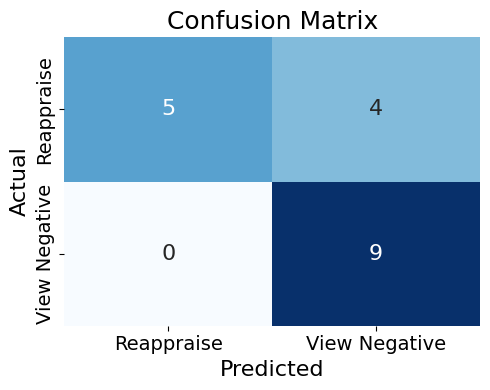

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix
confusion_matrix = np.array([[5, 4],
                             [0, 9]])

# Labels for the axes
labels = ['Reappraise', 'View Negative']

# Plot the confusion matrix
plt.figure(figsize=(5, 4))  # Smaller overall box
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar=False, annot_kws={"size": 16})  # Larger annotations

# Add labels, title, and adjust font sizes
plt.xlabel('Predicted', fontsize=16)  # Larger font size for axes labels
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)  # Larger title font
plt.xticks(fontsize=14)  # Larger tick labels
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()